<a href="https://colab.research.google.com/github/MarcosVeniciu/Machine-learning_Identificacao_de_enfermidades_em_folhas_de_macieira/blob/main/CNN_Plant_Pathology_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Atualiza o tensorflow para o 2.10.0
!pip install --upgrade tensorflow

In [ ]:
!pip install -q kaggle
!pip install scikit-optimize

In [2]:
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.models import load_model
from skopt.callbacks import CheckpointSaver
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import backend as K
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from skopt import gp_minimize
from tensorflow import keras
from skopt import dump, load
from itertools import cycle
from skopt import callbacks
from numpy import asarray
import tensorflow as tf
from PIL import Image 
import pandas as pd
import random

print(tf.__version__)
print(keras.__version__)


2.8.2
2.8.0


# Preparação do DataSet

In [ ]:
# Upload do arquivo Kaggle.json
from google.colab import files
files.upload()

In [4]:
# Cria uma pasta chamada Keggle e copia o arquivo Json para ela.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Altera as permisções para o arquivo keggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download do DataSet que eu quero: https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/data
# É preciso aceitar as regras na aba de Rules para poder fazer o dosnloas do dataset

! kaggle competitions download -c plant-pathology-2020-fgvc7

100% 779M/779M [00:18<00:00, 38.5MB/s]
100% 779M/779M [00:18<00:00, 45.3MB/s]


In [ ]:
# Descompacta o arquivo plant-pathology-2020-fgvc7
! unzip plant-pathology-2020-fgvc7.zip

In [7]:
# healthy = 1 planta saldavel, healthy = 0 alguma doença: multiple_diseases, rust ou scab
dataset = pd.read_csv("/content/train.csv")
dataset

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [8]:
# Cria os diretórios para as imagens
!mkdir Imagens_plantas
!mkdir Imagens_plantas/healthy
!mkdir Imagens_plantas/multiple_diseases
!mkdir Imagens_plantas/rust
!mkdir Imagens_plantas/scab

In [9]:
# move as imagens de plantas saldaveis e doentes para a sua respectiva pasta em Imagens_plantas
import os
import shutil

for i in range (1821): #0 ate 1820
  caminho_origem =  "/content/images/Train_" + str(i) + ".jpg"

  if(dataset['healthy'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/healthy")
  if(dataset['multiple_diseases'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/multiple_diseases")
  if(dataset['rust'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/rust")
  if(dataset['scab'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/scab")


# Contar o numero de imagens nas pastas
print("PLantas saudaveis: "+ str(len(os.listdir("/content/Imagens_plantas/healthy"))))
print("PLantas com multiple diseases: "+ str(len(os.listdir("/content/Imagens_plantas/multiple_diseases"))))
print("PLantas com rust: "+ str(len(os.listdir("/content/Imagens_plantas/rust"))))
print("PLantas com scab: "+ str(len(os.listdir("/content/Imagens_plantas/scab"))))

PLantas saudaveis: 516
PLantas com multiple diseases: 91
PLantas com rust: 622
PLantas com scab: 592


## Data Augmentation

### Funções

In [10]:
# transformar uma imagem em um vetor.
def imagem_to_array(imagem_local):
  img = Image.open(imagem_local) 
  return asarray(img)

In [11]:
# transforma um vetor em imagem.
def array_to_imagem(imagem_array, novo_nome):
  data = tf.keras.preprocessing.image.array_to_img(imagem_array, data_format=None,scale=False,dtype=None)
  data.save(novo_nome)

In [12]:
# Transformaçoes disponiveis

def rotacao90(image):
  return tf.image.rot90(image, 1)

def rotacao180(image):
  return tf.image.rot90(image, 2)

def rotacao270(image):
  return tf.image.rot90(image, 3)

def saturation(image):
  return tf.image.adjust_saturation(image, 3)

def flip_up_down (image):
  seed = (2, 3)
  return tf.image.stateless_random_flip_up_down(image, seed)

def rotacao90_flip_left_right(image):
  imagem = tf.image.rot90(image, 1)
  return tf.image.flip_left_right(imagem)

def rotacao90_flip_up_down(image):
  seed = (2, 3)
  imagem = tf.image.rot90(image, 1)
  return tf.image.stateless_random_flip_up_down(imagem, seed)

In [13]:
# Transforma e salva as novas imagens

# Transformação 1
def transformacao_1 (imagem, local, nome):
  transformada = rotacao90(imagem)
  novo_nome = "rotacao90_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 2
def transformacao_2 (imagem, local, nome):
  transformada = rotacao180(imagem)
  novo_nome = "rotacao180_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 3
def transformacao_3 (imagem, local, nome):
  transformada = rotacao270(imagem)
  novo_nome = "rotacao270_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 4
def transformacao_4 (imagem, local, nome):
  transformada = rotacao90_flip_up_down(imagem)
  novo_nome = "rotacao90_flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 5
def transformacao_5 (imagem, local, nome):
  transformada = flip_up_down(imagem)
  novo_nome =  "flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 6
def transformacao_6 (imagem, local, nome):
  transformada = rotacao90_flip_left_right(imagem)
  novo_nome = "rotacao90_flip_left_right_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 7
def transformacao_7 (imagem, local, nome):
  transformada = saturation(imagem)
  novo_nome = "saturation_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

In [14]:
# Transforma e salva as novas imagens

# Transformação 1
def transformacao_1 (imagem, local, nome):
  transformada = rotacao90(imagem)
  novo_nome = "rotacao90_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 2
def transformacao_2 (imagem, local, nome):
  transformada = rotacao180(imagem)
  novo_nome = "rotacao180_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 3
def transformacao_3 (imagem, local, nome):
  transformada = rotacao270(imagem)
  novo_nome = "rotacao270_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 4
def transformacao_4 (imagem, local, nome):
  transformada = rotacao90_flip_up_down(imagem)
  novo_nome = "rotacao90_flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 5
def transformacao_5 (imagem, local, nome):
  transformada = flip_up_down(imagem)
  novo_nome =  "flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 6
def transformacao_6 (imagem, local, nome):
  transformada = rotacao90_flip_left_right(imagem)
  novo_nome = "rotacao90_flip_left_right_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 7
def transformacao_7 (imagem, local, nome):
  transformada = saturation(imagem)
  novo_nome = "saturation_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)
def DataAugmentation (local, total):
  lista = os.listdir(local) #lisa com o nome das imagens que estão na pasta

  indices_sorteados = random.sample(range(len(lista)), len(lista)) # sorteia as imagens que seram tranformadas

  contagem = len(lista)# definida uma unica vez

  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_1 (imagem, local, nome) # rotacao 90

    contagem = contagem +1
    indice = indice +1

  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_2 (imagem, local, nome) # rotacao 180

    contagem = contagem +1
    indice = indice +1

  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_3 (imagem, local, nome) # rotacao 270

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_4 (imagem, local, nome) # rotacao 90 + flip up down

    contagem = contagem +1
    indice = indice +1


  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_5 (imagem, local, nome) # flip up down

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_6 (imagem, local, nome) # rotacao 90 + flip left right

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_7 (imagem, local, nome) # saturation

    contagem = contagem +1
    indice = indice +1

In [15]:
# Contar o numero de imagens nas pastas

def Contar_Imagens(locais):
  for local in locais:
    print(local )
    print(len(os.listdir(local)))

### Aplicando o aumento de imagens

In [16]:
# Aplicas varias transformações em todas as imagens presentes nas classes.
total = 637 #Total de imagens por classe

locais = ["/content/Imagens_plantas/healthy/", "/content/Imagens_plantas/multiple_diseases/",
          "/content/Imagens_plantas/rust/","/content/Imagens_plantas/scab/"]

for local in locais:# Percorre todos as classes
  # Realiza o aumento de dados
  DataAugmentation (local, total) # Realiza o aumento de dados na classe


# Contar o numero de imagens nas pastas
print("PLantas saudaveis: "+ str(len(os.listdir("/content/Imagens_plantas/healthy"))))
print("PLantas com multiple diseases: "+ str(len(os.listdir("/content/Imagens_plantas/multiple_diseases"))))
print("PLantas com rust: "+ str(len(os.listdir("/content/Imagens_plantas/rust"))))
print("PLantas com scab: "+ str(len(os.listdir("/content/Imagens_plantas/scab"))))

PLantas saudaveis: 637
PLantas com multiple diseases: 637
PLantas com rust: 637
PLantas com scab: 637


# Preparação do Modelo

## Pré-processamento das imagens de treino e validação

In [17]:
image_size = (180, 180)
batch_size = 32

In [18]:
diretorio_imagens = "/content/Imagens_plantas"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # 20% das imagens serão para validação e os 80% restantes seram para o treino
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
   # shuffle=False,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # 20% das imagens serão para validação e os 80% restantes seram para o treino
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    #shuffle=False,
)

Found 2548 files belonging to 4 classes.
Using 2039 files for training.
Found 2548 files belonging to 4 classes.
Using 509 files for validation.


In [ ]:
imagem = 

In [19]:
# Configurando o dataset
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [20]:
# Aplicando algumas transformações nas imagens, para aumentar o dataset

data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.12),
    ]
)

In [ ]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 
# healthy = 0, multiple_diseases = 1, rust = 2, scab = 3

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Modelos

In [21]:
def MobileNetV2(input_shape, num_classes, dropout):
  base_model = keras.applications.MobileNetV2(
    weights= None,  # Os pesos serão inicializados aleatóriamente.
    input_shape= input_shape,
    alpha=1.0,
    include_top=False, # Não vai incluir a camada de classificação.
  )

  # Freeze the base_model
  base_model.trainable = True # Sendo True vai permitir que os pesos sejam atualizados durante o treinamento

  inputs = keras.Input(shape = input_shape)
  x = data_augmentation(inputs)  # Apply random data augmentation

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)

  x = base_model(x, training=True)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = keras.layers.Dropout(dropout, name="dropout_2")(x) # Regularize with dropout
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dense(320, activation='relu')(x)
  outputs = keras.layers.Dense(units, activation=activation)(x)
  
  return keras.Model(inputs, outputs)

In [ ]:
def xception(input_shape, num_classes, dropout):
  base_model = keras.applications.Xception(
    weights=None,  # Os pesos serão inicializados aleatóriamente.
    input_shape=input_shape,
    include_top=False, # Não vai incluir a camada de classificação
  )  

  # freeze the base_model
  base_model.trainable = True # Sendo True vai permitir que os pesos sejam atualizados durante o treinamento

  # Create new model on top
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)  # Apply random data augmentation

  # Pre-trained Xception weights requires that input be scaled
  # from (0, 255) to a range of (-1., +1.), the rescaling layer
  # outputs: `(inputs * scale) + offset`
  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)
  
  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here.
  x = base_model(x, training=True)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = keras.layers.Dropout(dropout, name="dropout_2")(x) # Regularize with dropout
  x = keras.layers.Dense(1024, activation=activation)(x)
  x = keras.layers.Dense(512, activation=activation)(x)
  outputs = keras.layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

In [ ]:
# Precisa do tensorflow 2.10.0 para poder usa-lo
def ConvNeXtTiny(input_shape, num_classes, dropout):
  base_model = tf.keras.applications.convnext.ConvNeXtTiny(
    include_top=False,
    include_preprocessing=True,
    weights=None,
    input_shape=input_shape,
)

  # Freeze the base_model
  base_model.trainable = True # Sendo True vai permitir que os pesos sejam atualizados durante o treinamento

  inputs = keras.Input(shape = input_shape)
  x = data_augmentation(inputs)  # Apply random data augmentation

  #scale_layer = keras.layers.Rescaling(scale=1./255)
  #x = scale_layer(x)

  x = base_model(x, training=True)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = keras.layers.Dropout(dropout, name="dropout_2")(x) # Regularize with dropout
  x = keras.layers.Dense(384, activation=activation)(x)
  x = keras.layers.Dense(192, activation=activation)(x)
  outputs = keras.layers.Dense(units, activation=activation)(x)
  
  return keras.Model(inputs, outputs)

# Ajuste de Hyperparâmetro

In [23]:
nome_modelo = "MobileNet_DataAugm"
best_score = 10.0 # Avaliando a taxa de loss
best_historico = []

In [24]:
espera = 3 
espera_2 = 5
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                              mode = "min",
                                              patience = espera,
                                              factor=0.2,# 20% da taxa atual, reduz em 80%. nova lr = lr * fator
                                              min_lr=0.0000001, # reduz até 1e-7
                                              verbose = 1)
earlystopping =  keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                               mode ="min", 
                                               patience = espera_2, 
                                               restore_best_weights = True)

## Configuração da função objetivo.

In [25]:
# Intervalo dos hyperparametros
dim_taxa_aprendizado = Real(low=1e-6, high=1e-1, prior='log-uniform',name='learning_rate')

dimensions = [dim_taxa_aprendizado]

In [26]:
dropout = 0.6
num_classes = 4
iteracao = 1

@use_named_args(dimensions=dimensions)
def fitness(learning_rate):

  # Cria um modelo usando os hyper-parameters especificados.
  model = MobileNetV2(input_shape = image_size + (3,), num_classes = num_classes, dropout = dropout)  

  # Compila o modelo com a taxade aprendizado especificado.
  optimizer= keras.optimizers.Adam(learning_rate = learning_rate)

  loss_function = "SparseCategoricalCrossentropy" if num_classes >= 3 else "binary_crossentropy"
  model.compile(optimizer = optimizer, loss= loss_function, metrics=["accuracy"],)

  historico = model.fit(train_ds, epochs = 40, callbacks = [earlystopping, reduce_lr], validation_data = val_ds, verbose = 2)

  score = model.evaluate(val_ds, steps = 10, verbose=0)
  accuracy = score[1]
  loss = score[0]

  global best_score
  global best_historico

  if loss < best_score:
    local = nome_modelo + ".h5"
    model.save(local)
    best_accuracy = accuracy
    best_historico = historico

  del model
  K.clear_session()

  global iteracao
  print()
  print()
  print("Iteração: {3} ||Acurácia: {0:.4f} || Loss: {1:.6f} || Taxa de Aprendizado: {2: .1e}".format(accuracy, loss, learning_rate, iteracao))
  print("-------------------------------------------------------------------------------")
  iteracao = iteracao +1
  # Vai minimizar a taxa de loss
  return loss


## Busca de Hiperparâmetros

In [ ]:
# Continuar com uma execução anterior
local_salvar = "/content/checkpoint.pkl"
res = load(local_salvar)
x0 = res.x_iters
y0 = res.func_vals

print("Total de Iterações já realizadas: " + str(len(res.func_vals)))

In [ ]:
local_salvar = "/content/checkpoint_data_augmentation.pkl"
checkpoint_saver = CheckpointSaver(local_salvar,  store_objective=False) 
res = gp_minimize(func=fitness,
                    dimensions=dimensions,
                    #x0=x0,                # already examined values for x
                    #y0=y0,                # observed values for x0
                    acq_func='EI',        # Expected Improvement.
                    n_initial_points = 3, # numero de pontos aleatórios testados, antes de fazer a aproximação.
                    n_calls = 10,     # Numero total de iterações da função.
                    callback=[checkpoint_saver])

In [ ]:
#

# Execução normal

In [27]:
lr = 0.004694027
dropout = 0.6
num_classes = 4

model = MobileNetV2(input_shape = image_size + (3,), num_classes = num_classes, dropout = dropout)  

optimizer= keras.optimizers.Adam(learning_rate = lr)
loss_function = "SparseCategoricalCrossentropy" if num_classes >= 3 else "binary_crossentropy"
model.compile(optimizer = optimizer, loss= loss_function, metrics=["accuracy"],)

best_historico = model.fit(train_ds, epochs = 40, callbacks = [earlystopping, reduce_lr], validation_data = val_ds, verbose = 1)



score = model.evaluate(val_ds, steps = 10, verbose=0)
accuracy = score[1]
loss = score[0]

local =  nome_modelo + ".h5"
model.save(local)

print("Acuracia: " + str(accuracy))
print("Loss: " + str(loss))

Epoch 1/40
64/64 [==============================] - 36s 252ms/step - loss: 1.5585 - accuracy: 0.2815 - val_loss: 1.3536 - val_accuracy: 0.3360 - lr: 0.0047
Epoch 2/40
64/64 [==============================] - 23s 333ms/step - loss: 1.3413 - accuracy: 0.3261 - val_loss: 1.3286 - val_accuracy: 0.3340 - lr: 0.0047
Epoch 3/40
64/64 [==============================] - 23s 333ms/step - loss: 1.3325 - accuracy: 0.3364 - val_loss: 1.2913 - val_accuracy: 0.3536 - lr: 0.0047
Epoch 4/40
64/64 [==============================] - 23s 328ms/step - loss: 1.2939 - accuracy: 0.3821 - val_loss: 1.2322 - val_accuracy: 0.4656 - lr: 0.0047
Epoch 5/40
64/64 [==============================] - 23s 330ms/step - loss: 1.1700 - accuracy: 0.4659 - val_loss: 1.0591 - val_accuracy: 0.5108 - lr: 0.0047
Epoch 6/40
64/64 [==============================] - 24s 342ms/step - loss: 1.0481 - accuracy: 0.5297 - val_loss: 1.0765 - val_accuracy: 0.5069 - lr: 0.0047
Epoch 7/40
64/64 [==============================] - 23s 332ms/st

In [ ]:
# 

# Predições

In [ ]:
# Cria um dataframe vazio para as previsões do modelo
df = pd.DataFrame([], columns=['classe_real', 'predicao'])
df

In [31]:
# Carrega o melhor modelo
local_modelo = "/content/"+ local
model = load_model(local_modelo)

In [37]:
model.evaluate(val_ds)

16/16 [==============================] - 6s 180ms/step - loss: 0.2660 - accuracy: 0.9136


[0.2660005986690521, 0.9135559797286987]

In [33]:
y_true = []
y_pred = []
for image_batch, labels_batch in val_ds:
  y_pred_itera = model.predict(image_batch)
  y_true_intera = labels_batch.numpy()
  for i in range(len(y_true_intera)):
    y_true.append(y_true_intera[i])  
    y_pred.append(y_pred_itera[i][0])


for i in range(len(y_pred)):
  df = df.append({'classe_real' : y_true[i], 'predicao': y_pred[i]} ,ignore_index=True)   
df

#Criando o CSV
nome_modelo = nome_modelo
Nome_arquivo = "classificacao_" + nome_modelo + ".csv"
df.to_csv(Nome_arquivo, index = False)

# Resultados

In [ ]:
plot_convergence(res)

In [ ]:
# Melhores parâmetros
print("Loss: " + str(res.fun))
print("""Melhores parâmetros:
- Taxa de aprendizado = %.9f""" % (res.x[0]))

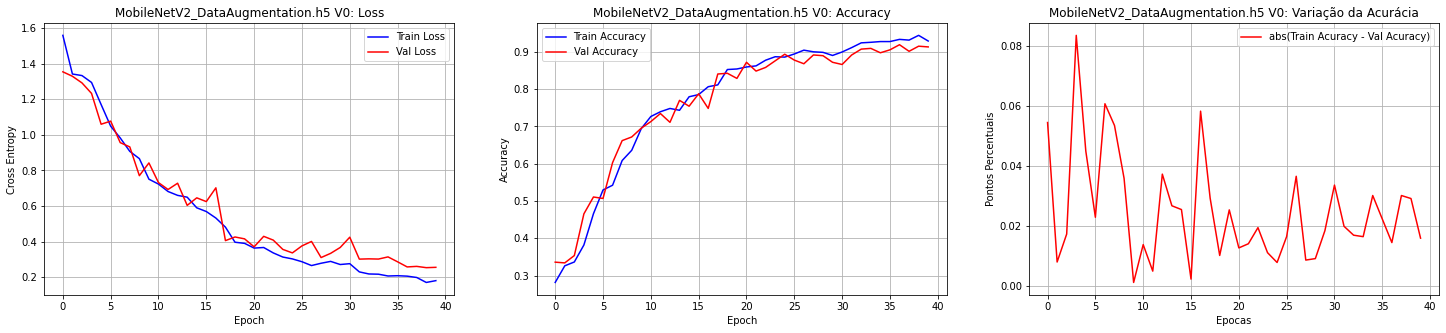

In [34]:
# Curva de Aprendizado

def diferenca(historico):
  accuracy = historico.history['accuracy'] 
  val_accuracy = historico.history['val_accuracy']
  vetor_diferenca = []

  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

historicos = [best_historico]
for i in range(len(historicos)):

  historico = historicos[i]

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,3,1)
  plt.title(nome_modelo + ' V' + str(i) + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss', color = 'red')
  plt.legend()

  # Grafico 2: Acurácia
  plt.subplot(1,3,2)
  plt.title(nome_modelo + ' V' + str(i) + ': Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.plot(historico.history['accuracy'],  label='Train Accuracy' , color = 'blue')
  plt.plot(historico.history['val_accuracy'],label = 'Val Accuracy', color = 'red')
  plt.legend()

  # Grafico 3: Diferença de Acurácia
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,3,3)
  plt.title(nome_modelo + " V"+ str(i) + ": Variação da Acurácia")
  plt.xlabel("Epocas")
  plt.ylabel("Pontos Percentuais")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'abs(Train Acuracy - Val Acuracy)')
  plt.legend()

  plt.show()